# CMAP analysis

In this notebook we analyze available gene expressio data from the CMAP data set of U2OS cells in various overexpression conditions including those covered in our structural regulators. The idea is to better understand the clustering of the gene expression profiles and the corresponding co-clustering with the currently inferred pyhsical space estimate. Additionally, we aim to preprocess the data such that it can be used later to infer the regulatory network of U2OS cells which will be the basis for the modelling of the regulatory space.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in all the required data sets which include the CMAP data and corresponding metadata as well as a number of gene sets that we will look at later in order to compare the observed structure to our inferred structural space, which we will also load into membry.

In [2]:
sig_info = pd.read_csv("../../../data/gex/cmap/siginfo_beta.txt", sep="\t")
gene_info = pd.read_csv("../../../data/gex/cmap/geneinfo_beta.txt", sep="\t")
cell_info = pd.read_csv("../../../data/gex/cmap/cellinfo_beta.txt", sep="\t")
l5_oe_gex_data = parse(
    "../../../data/gex/cmap/level5_beta_trt_oe_n34171x12328.gctx"
).data_df.transpose()
l5_ctl_gex_data = parse(
    "/home/paysan_d/Downloads/level5_beta_ctl_n58022x12328.gctx"
).data_df.transpose()
l5_oe_gex_data = l5_ctl_gex_data.append(l5_oe_gex_data)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>

In [3]:
struct_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
struct_embs.loc[:, "labels"] = np.array(struct_embs.labels.map(label_dict))
mean_struct_embs = struct_embs.groupby("labels").mean()

oe_targets = set(mean_struct_embs.index) - {"EMPTY"}

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

To preprocess the data, we briefly filter out any signatures of the CMAP data set that are not related to any of structural regulators and or were not obtained from our cell type of interest: U2OS.

In [5]:
sig_info = sig_info.loc[
    (sig_info["project_code"] == "TA") & (sig_info["cell_iname"] == "U2OS")
]
sig_info = sig_info.loc[sig_info["pert_type"].isin(["trt_oe", "ctl_untrt"])]
# sig_info = sig_info.loc[sig_info["cmap_name"].isin(list(oe_targets))]
sig_info.index = np.array(sig_info.sig_id)
sig_info.head(5)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
TA.OE005_U2OS_72H:BRDN0000464889:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464889,...,U2OS,O02,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:O02|TA.OE005_U2OS_72H...,NaN,TA,SMAD3,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000407676:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000407676,...,U2OS,I01,TA.OE005_U2OS_72H_X1_B15,TA.OE005_U2OS_72H_X1_B15:I01,NaN,TA,WNT5A,0,0.0,0.0
TA.OE005_U2OS_72H:BRDN0000464938:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464938,...,U2OS,J01,TA.OE005_U2OS_72H_X1_B15,TA.OE005_U2OS_72H_X1_B15:J01,NaN,TA,HSP90B1,0,0.0,0.0
TA.OE005_U2OS_72H:BRDN0000459386:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000459386,...,U2OS,G04,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:G04|TA.OE005_U2OS_72H...,NaN,TA,PIK3CA,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000399961:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000399961,...,U2OS,O13,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:O13|TA.OE005_U2OS_72H...,NaN,TA,TP53,0,0.0,0.0


<IPython.core.display.Javascript object>

There are 325 gene signatures available in total corresponding to the different OE and control experiments with U2OS cells. There are 61 gene signatures available for all 41 structural regulators. Note that only 49/64 of these signatures are flagged as being of high quality. We note that the poor quality measurements correlate with interventions that had been flagged as having a toxic effect thus killing a substantial amount of the cells.

We will construct averaged gene sigantures for each overexpression conditions described above.

In [6]:
gene_id_symbol_dict = dict(
    zip(gene_info.loc[:, "gene_id"].astype(str), gene_info.loc[:, "gene_symbol"])
)
l5_oe_gex_data = l5_oe_gex_data.rename(gene_id_symbol_dict, axis=1)
l5_data = l5_oe_gex_data.loc[set(sig_info.sig_id)].copy()
l5_data["labels"] = np.array(sig_info.loc[l5_data.index, "cmap_name"])
mean_l5_data = l5_data.copy()
mean_l5_data["labels"] = np.array(sig_info.loc[mean_l5_data.index, "cmap_name"])
mean_l5_data = mean_l5_data.groupby("labels").mean()
mean_l5_data.head()

rid,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,SCO2
labels,,,,,,,,,,,,,,,,,,,,,
ACVR1B,0.382983,0.273100,0.556467,0.014800,0.108117,0.368000,0.534183,0.390683,-0.214333,0.201783,...,0.541300,-0.179367,-0.463917,0.169100,-1.299350,-0.120550,-0.093567,0.095350,0.599783,0.324317
ADAM17,-0.321200,-0.866750,-0.070550,0.100850,-0.393200,1.122850,0.036250,0.468750,-0.743700,0.034900,...,0.345050,-0.369750,-0.322050,-0.210700,1.434200,0.058050,-0.212450,0.599150,-0.007250,1.124700
AKT1,-0.516100,-0.810000,0.099400,-0.500933,-0.105000,-0.560267,0.071867,0.357167,-0.135917,-0.618183,...,0.356483,0.234067,0.362783,0.904867,-0.072367,-0.444233,0.559650,0.015817,-0.102150,0.212633
AKT1S1,0.161675,-0.486725,0.648050,0.880625,-0.174125,1.154400,0.192925,0.297125,-0.207900,0.863800,...,0.080525,0.684025,-0.573075,0.495225,-1.047250,0.352625,0.582375,-0.536525,-0.496625,0.970000
AKT2,-1.160950,0.428450,-0.063650,-1.065950,-0.131850,-0.108450,0.117800,-0.130300,-0.584200,0.209750,...,-0.220450,1.569800,-1.108100,0.556550,0.411900,-0.621400,0.083950,-0.689700,-0.603000,1.102050


<IPython.core.display.Javascript object>

---

## 3. Exploratory analysis


### 3.1. Gene coverage

Next, we focus on the genes captured in the computed signatures and look at the coverage of our structural regulators in gene subsets of different inference quality.

In [7]:
l1000_genes = set(gene_info.loc[gene_info.feature_space == "landmark", "gene_symbol"])
best_inf_genes = set(
    gene_info.loc[gene_info.feature_space == "best inferred", "gene_symbol"]
)
inf_genes = set(gene_info.loc[gene_info.feature_space == "inferred", "gene_symbol"])
not_rep_genes = set(
    gene_info.loc[gene_info.feature_space == "not reported", "gene_symbol"]
)

<IPython.core.display.Javascript object>

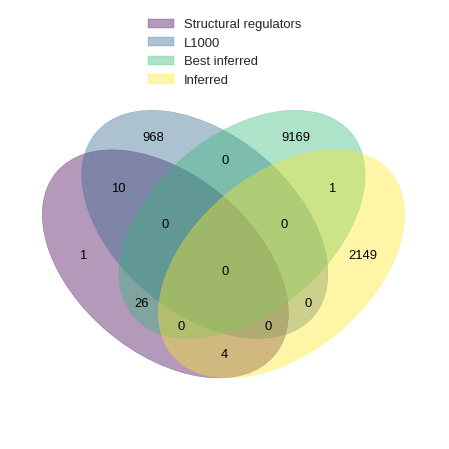

<IPython.core.display.Javascript object>

In [8]:
ax = venn(
    {
        "Structural regulators": oe_targets,
        "L1000": l1000_genes,
        "Best inferred": best_inf_genes,
        "Inferred": inf_genes,
    },
    legend_loc="upper center",
)

We find that 10/41 structural regulators are in the L1000 gene set, 26/41 of the regulators are in the set of best inferred genes and just one structural regulatory, namely AKT1S1 is not covered in the gene set.

---

### 3.2. Clustering of the gene signatures

In [9]:
l1000_genes.intersection(oe_targets)

{'BAX',
 'CDC42',
 'CDKN1A',
 'CEBPA',
 'CREB1',
 'JUN',
 'PRKACA',
 'RELB',
 'RHOA',
 'SRC'}

<IPython.core.display.Javascript object>

As a first step we aim to understand the similarity of the gene signatures with our inferred structural embeddings.


#### Clustering of the physical space

To this end, we will briefly cluster the physical space and compare it to the gene signatures. Since the gene signatures are describing pooled differential expression levels, we will also pool our structural embeddings and cluster the mean embeddings for each gene.

We next will identify the optimal number of clusters in the structural space by looking at the a number of metrics proposed earlier.

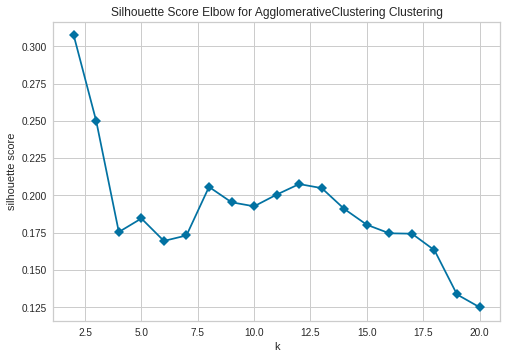

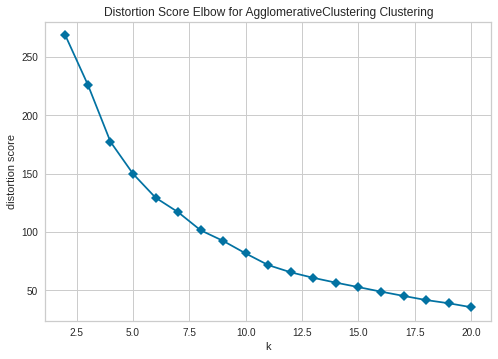

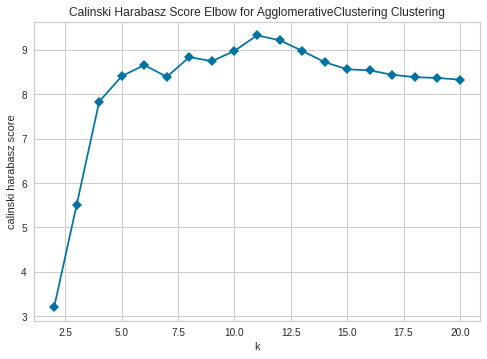

<IPython.core.display.Javascript object>

In [103]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

The above plots indicate that the data is best divided into 11 clusters as this maximizes the Calinski-Harabsz score and reaches a local optima of the Silhouette score. Thus, we focus at the solution consisting of 11 clusters.

In [91]:
model = AgglomerativeClustering(n_clusters=11, affinity="euclidean", linkage="complete")
struct_cluster_labels = model.fit_predict(mean_struct_embs.loc[oe_targets])
struct_clusters = pd.DataFrame(
    struct_cluster_labels,
    index=mean_struct_embs.loc[oe_targets].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(struct_cluster_labels)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "tab:purple",
            "tab:pink",
            "tab:olive",
            "olivedrab",
            "tab:brown",
        ],
    )
)
struct_colors = pd.Series(
    struct_cluster_labels,
    index=mean_struct_embs.loc[oe_targets].index,
).map(lut)

<IPython.core.display.Javascript object>

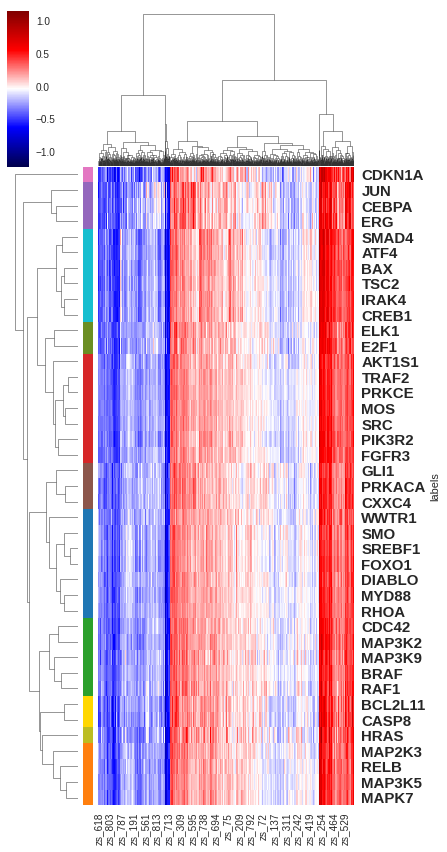

<IPython.core.display.Javascript object>

In [92]:
ax = sns.clustermap(
    mean_struct_embs.loc[oe_targets],
    figsize=[6, 12],
    metric="euclidean",
    cmap="seismic",
    method="complete",
    row_colors=np.array(struct_colors.loc[mean_struct_embs.loc[oe_targets].index]),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

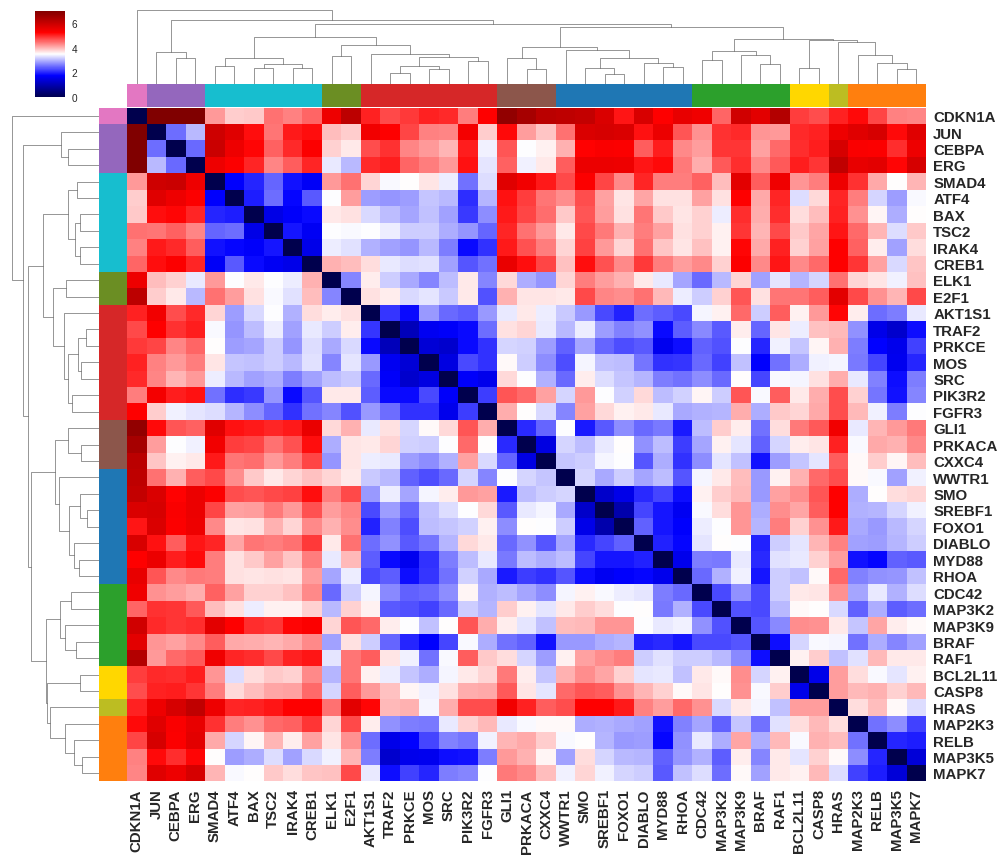

<IPython.core.display.Javascript object>

In [93]:
from scipy.spatial.distance import squareform, pdist

mean_struct_embs_dist = pd.DataFrame(
    squareform(pdist(mean_struct_embs.loc[oe_targets])),
    index=mean_struct_embs.loc[oe_targets].index,
    columns=mean_struct_embs.loc[oe_targets].index,
)

linkage = hc.linkage(squareform(mean_struct_embs_dist), method="complete")

ax = sns.clustermap(
    mean_struct_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="seismic",
    row_colors=np.array(struct_colors.loc[mean_struct_embs_dist.index]),
    col_colors=np.array(struct_colors.loc[mean_struct_embs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

In [89]:
print(list(mean_struct_embs_dist))

['PIK3R2', 'SREBF1', 'BCL2L11', 'CASP8', 'CDKN1A', 'CEBPA', 'RELB', 'IRAK4', 'ELK1', 'BRAF', 'WWTR1', 'FOXO1', 'TRAF2', 'E2F1', 'FGFR3', 'BAX', 'SMAD4', 'PRKACA', 'CXXC4', 'JUN', 'GLI1', 'RAF1', 'TSC2', 'DIABLO', 'MAP3K5', 'AKT1S1', 'CDC42', 'HRAS', 'MYD88', 'PRKCE', 'CREB1', 'ATF4', 'MAP2K3', 'MAP3K2', 'MAPK7', 'RHOA', 'ERG', 'MAP3K9', 'MOS', 'SMO', 'SRC']


<IPython.core.display.Javascript object>

In [90]:
cluster_dict = {}
for cluster_label in np.unique(struct_clusters.cluster):
    cluster_dict[cluster_label] = list(
        np.array(list(struct_clusters.index))[struct_clusters.cluster == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['SREBF1', 'WWTR1', 'FOXO1', 'DIABLO', 'MYD88', 'RHOA', 'SMO']

Cluster 1: ['PIK3R2', 'TRAF2', 'FGFR3', 'AKT1S1', 'PRKCE', 'MOS', 'SRC']

Cluster 2: ['BRAF', 'RAF1', 'CDC42', 'MAP3K2', 'MAP3K9']

Cluster 3: ['BCL2L11', 'CASP8']

Cluster 4: ['RELB', 'MAP3K5', 'MAP2K3', 'MAPK7']

Cluster 5: ['IRAK4', 'BAX', 'SMAD4', 'TSC2', 'CREB1', 'ATF4']

Cluster 6: ['CEBPA', 'JUN', 'ERG']

Cluster 7: ['CDKN1A']

Cluster 8: ['HRAS']

Cluster 9: ['ELK1', 'E2F1']

Cluster 10: ['PRKACA', 'CXXC4', 'GLI1']



<IPython.core.display.Javascript object>

---

#### Clustering of the functional (CMAP signature) space

Next, we cluster the CMAP signatures again using hierarchical clustering with complete linkage but using cosine similarity to identify cluster of overexpression settings that lead to changes of the same directionality in the gene expression space. To visualize the correspondence of the clustering of the functional and physical space, the physical space clusters are transfered by color-coding the corresponding genes in the cluster map below.

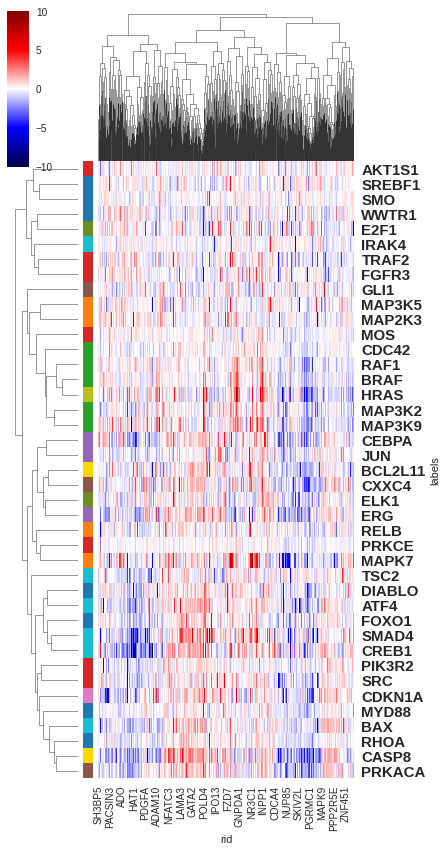

<IPython.core.display.Javascript object>

In [95]:
ax = sns.clustermap(
    mean_l5_data.loc[oe_targets, l1000_genes],
    figsize=[6, 12],
    metric="cosine",
    cmap="seismic",
    method="complete",
    row_colors=np.array(struct_colors.loc[mean_l5_data.loc[oe_targets].index]),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

The plot above suggests that there is a non-random co-clustering of the physical and the functional space as e.g. the green cluster of BRAF, RAF1, MAP3K2, MAP3K9 and HRAS are observed in both spaces. Additionaly we observe a number of gene pairs co-clustering in the two spaces like JUN and CEBPA or CREB1 and SMAD4.

The non-random agreement of the co-clustering of the physical and the CMAP space is further shown in the plot below showing the bootstrap p-values for the mutual information of for varying number of clusters in the physical and functional space obtained via hierarchical clustering using complete linkage and euclidean and cosine simularity respectively. We obtained 500 bootstrap samples by randomly permuting the cluster labels for each pair of cluster solutions defined by the corresponding dendogram cut in the two clustered spaces following the procedure described in .

In [96]:
# We will focus on all genes that are covered in the physical and functional (CMAP) space
shared_genes = set(mean_struct_embs.index).intersection(mean_l5_data.index)

<IPython.core.display.Javascript object>

In [98]:
cmap_perm_test_results = compute_cc_scores_perm_test(
    mean_struct_embs.loc[shared_genes],
    mean_l5_data.loc[shared_genes, l1000_genes],
    linkages=["complete", "complete"],
    affinities=["euclidean", "cosine"],
    score="mi",
    b=1000,
    n_max_clusters=len(shared_genes),
)

100%|██████████| 1000/1000 [18:28<00:00,  1.11s/it]


<IPython.core.display.Javascript object>

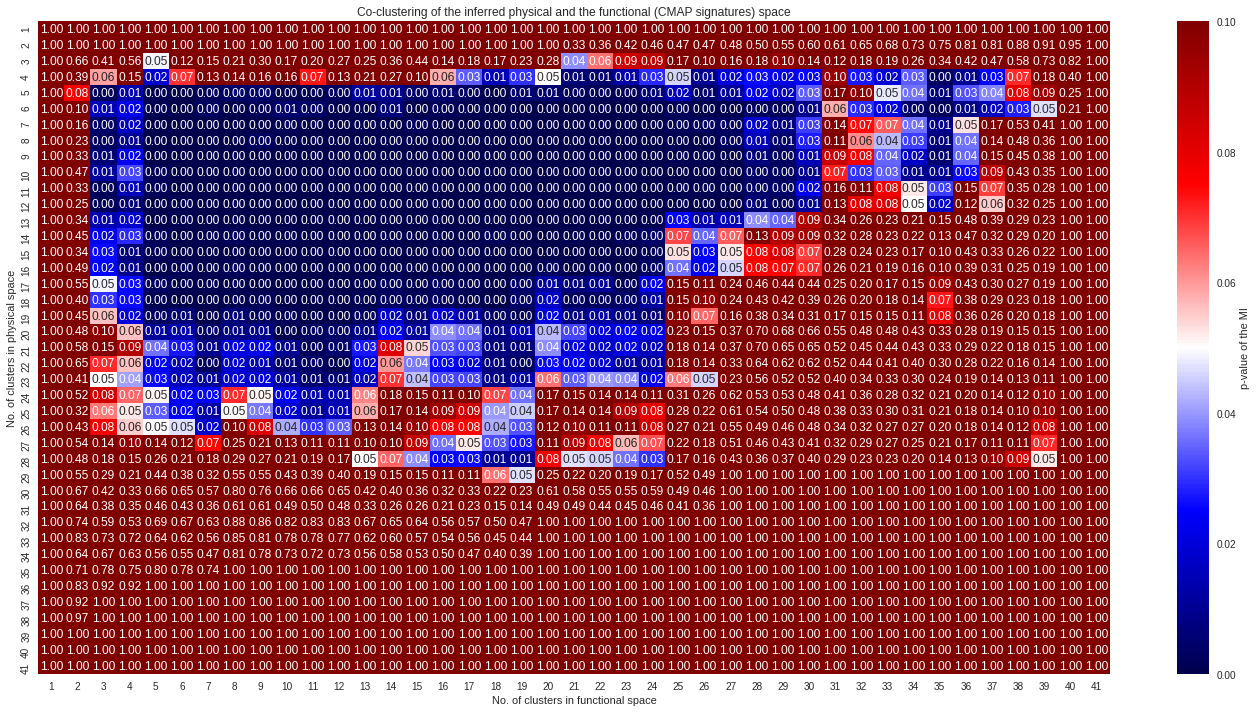

<IPython.core.display.Javascript object>

In [99]:
plot_cc_score(
    np.clip(cmap_perm_test_results["pval"], 0, 1),
    "Co-clustering of the inferred physical and the functional (CMAP signatures) space",
    "p-value of the MI",
    figsize=[24, 12],
    fmt=".2f",
    cmap="seismic",
    vmin=0,
    vmax=0.1,
    space_names=["functional space", "physical space"],
)

In [102]:
cmap_perm_test_results["pval"][10, 10]

0.0

<IPython.core.display.Javascript object>

---

### 3.3. Information transfer

The observed co-clustering of the phyiscal and functional space has two major implications. First, it indicates that the proximity of gene targets in the physical space partially captures functional relationships between individual genes. Second, the transcriptional profiles upon overexpression estimated by the CMAP signatures are a dictated by the regulatory links in the cell and the pathways in the cell triggering specific signaling cascades upon overexpression. Thus, the proximity in the functional space should partially translate to regulatory proximity of genes. 

We note that the inferred CMAP signatures as interventional data provide a power supplement to purely observational gene expression data for the inference of the regulatory space. It has previously been shown that activity of individual pathways and the role of the genes in those highly depends on the signal transduced to those. Thus, the use of the interventional gene expression data is important to identify the specific signaling cascades used by the cells in the different overexpression conditions. In addition to the CMAP signatures we will provide higher level information for the inference stemming from clustering the signature space.

To this end, we cluster the observed gene targets by their corresponding signatures as before using agglomerative clustering with complete linkage and cosine simularities. As before the optimal number of clusters is guided by an assessment of the Silhouette, distortion and Calinski-Harabasz score.

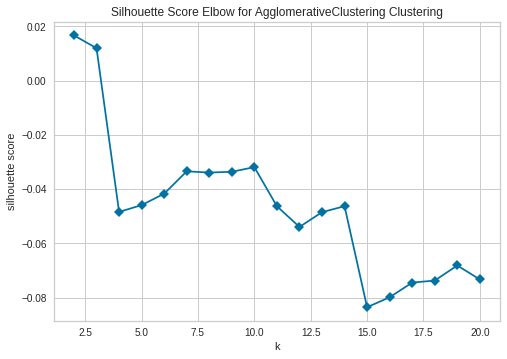

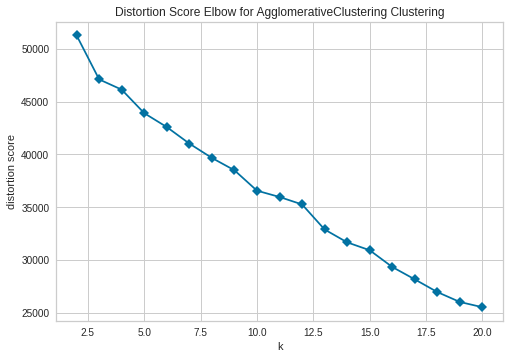

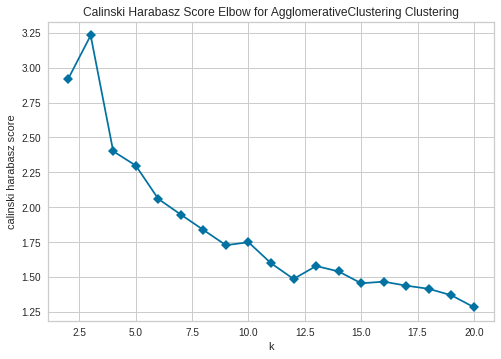

<IPython.core.display.Javascript object>

In [23]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
# model = KMeans(random_state=1234)
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[shared_genes, l1000_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[shared_genes, l1000_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[shared_genes, l1000_genes])
ax = visualizer.show()

We note that the above plots suggests dividing into three large clusters. However, we decide to overcluster the set of gene targets to give rise to smaller structures in the observed signature space. To this end, we at look the next local optima of the Calinski-Harabasz score which is achieved by a solution comprising of 10 clusters.

In [30]:
model = AgglomerativeClustering(n_clusters=7, affinity="cosine", linkage="complete")
l5_cluster_labels = model.fit_predict(mean_l5_data.loc[shared_genes, l1000_genes])
mean_l5_clusters = pd.DataFrame(
    l5_cluster_labels,
    index=mean_l5_data.loc[shared_genes].index,
    columns=["cluster"],
)

<IPython.core.display.Javascript object>

In [31]:
lut = dict(
    zip(
        list(np.unique(mean_l5_clusters)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "purple",
            "tab:pink",
            "tab:olive",
            "tab:cyan",
            "tab:brown",
        ],
    )
)
mean_l5_colors = pd.Series(
    np.array(mean_l5_clusters.cluster),
    index=mean_l5_clusters.index,
).map(lut)

<IPython.core.display.Javascript object>

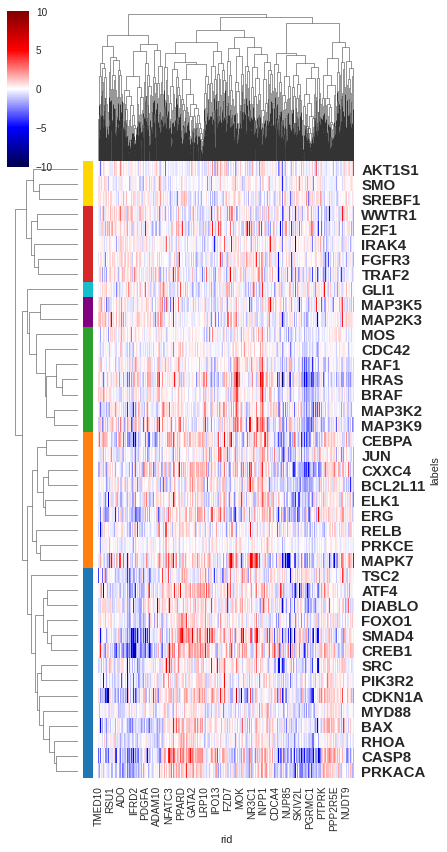

<IPython.core.display.Javascript object>

In [32]:
ax = sns.clustermap(
    mean_l5_data.loc[shared_genes, l1000_genes],
    figsize=[6, 12],
    metric="cosine",
    cmap="seismic",
    method="complete",
    row_colors=np.array(mean_l5_colors),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

---

## 4. Data export

As described above we aim to use the cluster structure as well as the "raw" CMAP signatures to guide the inference of the regulatory space to better capture the specific signaling cascade activated in the cells upon overexpression which are weakly described by purely observational data.

To this end, we will export the corresponding gene signature data set, the L1000 gene set information as well as the clusters identified clusters of the physical and CMAP signature space.

In [12]:
genes = list()

,cluster
labels,
PIK3R2,1
SREBF1,0
BCL2L11,3
CASP8,3
CDKN1A,7
CEBPA,6
RELB,4
IRAK4,5
ELK1,9


<IPython.core.display.Javascript object>

In [33]:
with open("../../../data/other/genesets/l1000.txt", "w") as f:
    for item in sorted(l1000_genes):
        f.write("%s\n" % item)

# mean_l5_data.to_csv("../../../data/gex/cmap/mean_l5_signatures.csv")
# struct_clusters.to_csv("../../../data/other/mean_physical_clusters.csv")
mean_l5_clusters.to_csv("../../../data/other/mean_cmap_sig_clusters2.csv")

<IPython.core.display.Javascript object>